In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import argparse

plt.switch_backend('agg')
# In[3]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:

from synthetic_dataloader import *


from synthetic_utils import *


# In[5]:


from trainer_dataloader import *
from networks import *
from losses import *


# In[6]:

In [3]:

input_size = 96
batch_size = 64
num_workers = 4


cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))


# In[8]:


data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
}



Device set: cuda


In [4]:
# if independent:
# DATA_PATH = '/home/s1791387/diss/gen_shapes/'
# else:
DATA_PATH = '/home/s1791387/diss/dependent_gen/'
print(DATA_PATH)
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

/home/s1791387/diss/dependent_gen/


In [5]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [6]:
LOAD_PATH = './dp2_nosig_dep/2/weights/encoder_493_0.79.pth'

In [7]:
laftr_encoder = torch.load(LOAD_PATH)

In [8]:
gender_train = ShapeDataset(train_df)
gender_valid = ShapeDataset(val_df)
gender_test = ShapeDataset(test_df)

In [9]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
advtest_loader = DataLoader(gender_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [10]:
classifier = ClassNet()

adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)

In [11]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_classifier_epoch(advtrain_loader, laftr_encoder,
                                classifier, opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_classifier_epoch(advval_loader, laftr_encoder, classifier,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 2.170 (2.170)	Loss 2.6788 (2.6788)	Accuracy 0.4062 (0.4062)
Batch: [10/79]	Time 0.091 (0.455)	Loss 1.0932 (1.1775)	Accuracy 0.4375 (0.4901)
Batch: [20/79]	Time 1.303 (0.444)	Loss 0.5198 (0.9656)	Accuracy 0.6250 (0.5402)
Batch: [30/79]	Time 0.048 (0.401)	Loss 0.5753 (0.8360)	Accuracy 0.7656 (0.5978)
Batch: [40/79]	Time 1.338 (0.412)	Loss 0.5208 (0.7540)	Accuracy 0.7656 (0.6361)
Batch: [50/79]	Time 0.051 (0.391)	Loss 0.5061 (0.7066)	Accuracy 0.7188 (0.6538)
Batch: [60/79]	Time 1.343 (0.397)	Loss 0.5297 (0.6797)	Accuracy 0.7656 (0.6660)
Batch: [70/79]	Time 0.052 (0.384)	Loss 0.4718 (0.6510)	Accuracy 0.7500 (0.6805)
----------


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Avg validation loss: 0.5365532479286194 	 Accuracy: 0.72
--------------------
Epoch 0/20	Time 33.953 sec (33.953 sec)
--------------------
Epoch: 1/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 2.075 (2.075)	Loss 0.6449 (0.6449)	Accuracy 0.6406 (0.6406)
Batch: [10/79]	Time 0.055 (0.461)	Loss 0.4248 (0.4987)	Accuracy 0.8594 (0.7670)
Batch: [20/79]	Time 1.309 (0.447)	Loss 0.4431 (0.4935)	Accuracy 0.7812 (0.7634)
Batch: [30/79]	Time 0.027 (0.401)	Loss 0.5980 (0.5035)	Accuracy 0.6719 (0.7571)
Batch: [40/79]	Time 1.296 (0.408)	Loss 0.5570 (0.5047)	Accuracy 0.7188 (0.7557)
Batch: [50/79]	Time 0.053 (0.387)	Loss 0.5116 (0.5045)	Accuracy 0.7656 (0.7564)
Batch: [60/79]	Time 1.322 (0.394)	Loss 0.5578 (0.4977)	Accuracy 0.7031 (0.7610)
Batch: [70/79]	Time 0.049 (0.380)	Loss 0.4811 (0.4935)	Accuracy 0.7969 (0.7641)
----------
Avg validation loss: 0.47876948046684265 	 Accuracy: 0.79
--------------------
Epoch 1/20	Time 33.425 sec (33.689 sec)
--------------------
Epoch: 2/20
Batch: [0/79]	Time 1.995 (1.995)	Loss 0.4762 (0.4762)	Accuracy 0.7188 (0.7188)
Batch: [10/79]	Time 0.055 (0.454)	Loss 0.4758 (0.4416)	Accuracy 0.7344 (0.7841)
Batch: [20/79]	Time 1.291 (0.443)	Loss 

No handles with labels found to put in legend.


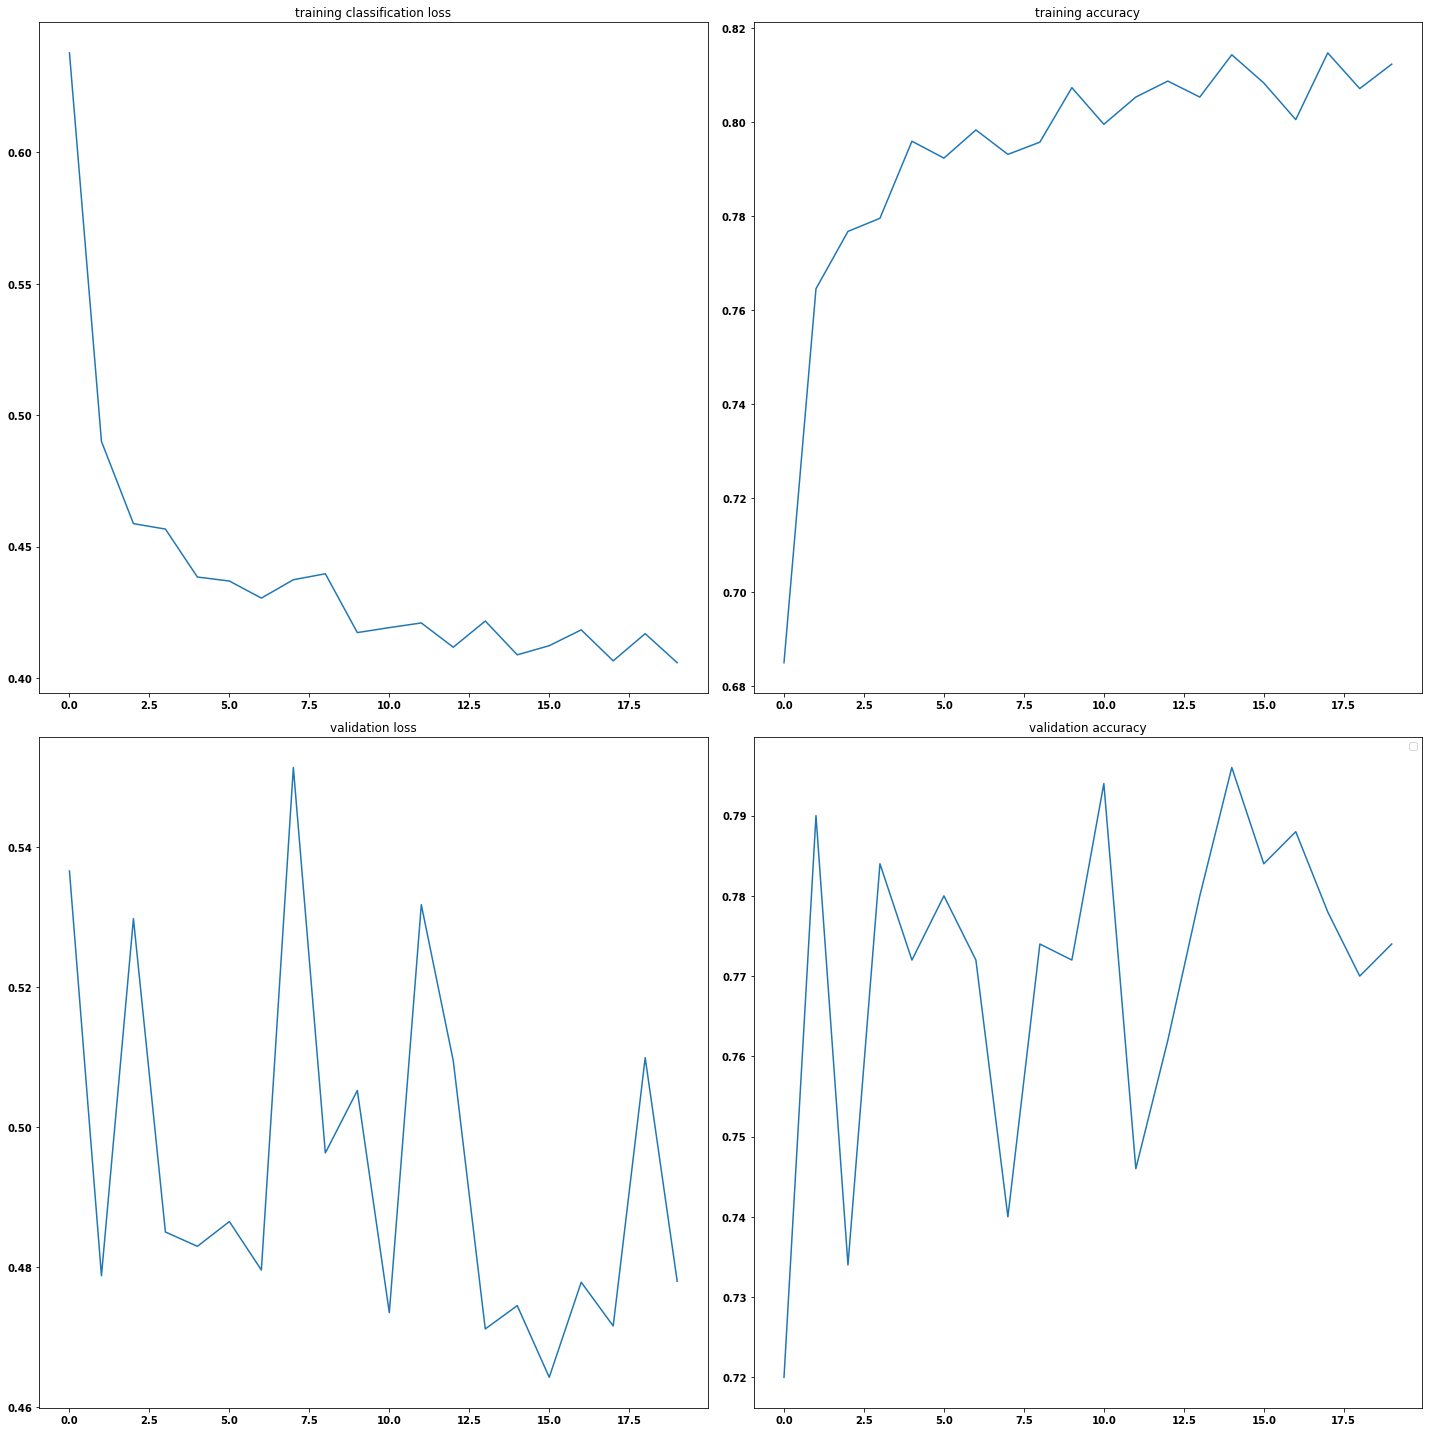

In [12]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)
plt.legend()
plt.tight_layout()

In [13]:
test_loss, test_acc = validate_classifier_epoch(advtest_loader, laftr_encoder, classifier,
                                 adv_criterion, device)

/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [14]:
test_loss, test_acc

(0.484138738155365, 0.76)